epoch:  0 , loss:  1.188844813015312
epoch:  1 , loss:  0.32827512790914626
epoch:  2 , loss:  0.2210465829243185
epoch:  3 , loss:  0.17807579335087212
epoch:  4 , loss:  0.15294292466773185
epoch:  5 , loss:  0.1363919103120861
epoch:  6 , loss:  0.12245325723139104
epoch:  7 , loss:  0.11234445548070653
epoch:  8 , loss:  0.10561633910976526
epoch:  9 , loss:  0.09724169328379503
epoch:  10 , loss:  0.09012715674369247
epoch:  11 , loss:  0.08594175371319579
epoch:  12 , loss:  0.07954457294937128
epoch:  13 , loss:  0.07640399017342134
epoch:  14 , loss:  0.07462315778308039
epoch:  15 , loss:  0.06936488036939409
epoch:  16 , loss:  0.06525771662036277
epoch:  17 , loss:  0.06614457541740194
epoch:  18 , loss:  0.06319886634559226
epoch:  19 , loss:  0.06170196894176115


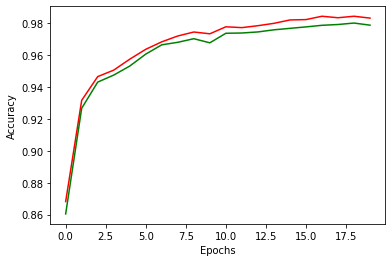


Test set: Average loss: -20.1045, Accuracy: 9890/10000 (99%)

Traning and Testing total excution time is: 677.9940559864044 seconds 


In [ ]:
import torch
torch.multiprocessing.set_start_method("spawn")
import torch.nn as nn
import torch.optim 
import torch.nn.functional as F
import torchvision.datasets   
import torchvision.transforms     

import numpy as np
import matplotlib
matplotlib.use('Agg')       
get_ipython().magic('matplotlib inline')
from matplotlib import pyplot    
from matplotlib.pyplot import subplot     
from sklearn.metrics import accuracy_score
from torchvision import datasets, transforms
import time

save_model = True
use_cuda = True
torch.manual_seed(100)
device = torch.device("cuda" if use_cuda else "cpu")
#downloading mnist data

transformImg = torchvision.transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])
train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transformImg)
valid = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transformImg)
test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transformImg)  

# creating a 80 to 20 ratio of data
idx = list(range(len(train)))
np.random.seed(1009)
np.random.shuffle(idx)          
train_idx = idx[ : int(0.8 * len(idx))]       
valid_idx = idx[int(0.8 * len(idx)) : ]


#Creating train val and test data sets
train_set = torch.utils.data.sampler.SubsetRandomSampler(train_idx)    
valid_set = torch.utils.data.sampler.SubsetRandomSampler(valid_idx)  


train_loader = torch.utils.data.DataLoader(train, batch_size=30, sampler=train_set, num_workers=4)  
valid_loader = torch.utils.data.DataLoader(train, batch_size=30, sampler=valid_set, num_workers=4)    
test_loader = torch.utils.data.DataLoader(test, num_workers=4)       


# Creating the Model  
class LeNet5(torch.nn.Module):          
     
    def __init__(self):     
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2, bias=True)
        self.max_pool_1 = nn.MaxPool2d(kernel_size=2)
        self.batchlayer1 = nn.BatchNorm2d(6) #batchnorm layer on conv
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, bias=True)
        self.max_pool_2 = nn.MaxPool2d(kernel_size=2)
        self.batchlayer2 = nn.BatchNorm2d(16) #batchnorm layer on conv
        self.fc1 = nn.Linear(16*5*5, 120)
        self.dropoutlayer1 = nn.Dropout()   #dropoutlayer after FC
        self.fc2 = nn.Linear(120, 84)
        self.dropoutlayer2 = nn.Dropout()     #dropoutlayer after FC  
        self.fc3 = nn.Linear(84, 10)       
        
    def forward(self, x):
        
        x = F.relu(self.conv1(x))  
        x = self.max_pool_1(x)
        #x = self.batchlayer1(x)   #batchnorm layer on conv
        x = F.relu(self.conv2(x))
        x = self.max_pool_2(x)
        #x = self.batchlayer2(x)  #batchnorm layer on conv
        x = x.view(-1, 16*5*5)   #flatten
        x = F.relu(self.fc1(x))
        x = self.dropoutlayer1(x)  #dropoutlayer after FC
        x = F.relu(self.fc2(x))
        x = self.dropoutlayer2(x)  #dropoutlayer after FC
        x = self.fc3(x)             #output layer
        
        return x
     
net = LeNet5()     
net.cuda()


# CrossEntropy Loss
loss_func = torch.nn.CrossEntropyLoss()
       
# SGD 
optimization = torch.optim.SGD(net.parameters(), lr = 0.001, momentum=0.9)


#Training
time0 = time.time()

numEpochs = 20    
training_accuracy = []     
validation_accuracy = []

for epoch in range(numEpochs):
    net.train()
    epoch_training_loss = 0.0
    num_batches = 0
    for batch_num, training_batch in enumerate(train_loader):
        inputs, labels = training_batch
        inputs, labels = torch.autograd.Variable(inputs.cuda()), torch.autograd.Variable(labels.cuda())
        optimization.zero_grad()
        forward_output = net(inputs)
        loss = loss_func(forward_output, labels)
        loss.backward()   
        optimization.step()
        epoch_training_loss += loss.item()
        num_batches += 1
        
    print("epoch: ", epoch, ", loss: ", epoch_training_loss/num_batches)            
     
    # Calculating accuracy for training data
    accuracy = 0.0 
    num_batches = 0
    for batch_num, training_batch in enumerate(train_loader):               
        num_batches += 1
        inputs, actual_val = training_batch
        predicted_val = net(torch.autograd.Variable(inputs.cuda()))
        predicted_val = predicted_val.cpu().data.numpy()  
        predicted_val = np.argmax(predicted_val, axis = 1)   
        accuracy += accuracy_score(actual_val.numpy(), predicted_val)
    training_accuracy.append(accuracy/num_batches)   

    # Calculating accuracy for val data 
    accuracy = 0.0 
    num_batches = 0
    for batch_num, validation_batch in enumerate(valid_loader):        
        num_batches += 1
        inputs, actual_val = validation_batch
        predicted_val = net(torch.autograd.Variable(inputs.cuda()))   
        predicted_val = predicted_val.cpu().data.numpy()   
        predicted_val = np.argmax(predicted_val, axis = 1)  
        accuracy += accuracy_score(actual_val.numpy(), predicted_val)
    validation_accuracy.append(accuracy/num_batches)




epochs = list(range(numEpochs))

# Plot of the accuracy for training and validation for comparison
fig1 = pyplot.figure()
pyplot.plot(epochs, training_accuracy, 'r')
pyplot.plot(epochs, validation_accuracy, 'g')
pyplot.xlabel("Epochs")
pyplot.ylabel("Accuracy") 
pyplot.show(fig1)




# Test
net.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = net(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
test_loss /= len(test_loader.dataset)

print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
time1 = time.time() 
print ('Traning and Testing total excution time is: %s seconds ' % (time1-time0))